# Stacked Models - 01 - Setup & Cleaning

## Imports and Setup.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml, time, sys, os

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  
sns.set_style("darkgrid")

DATASET = "okcupid-stem"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

SEED = 42
DEBUG = True

C:\Users\micha\AppData\Local\Temp\ipykernel_16588\1833754412.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [106]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

In [107]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Datasets

In [108]:
from openml.datasets import get_dataset

did = 41440

dataset = get_dataset(did)

print(f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)

This is dataset 'okcupid-stem', the target feature is 'job'


## Target

In [109]:
target = dataset.default_target_attribute
df, _, categorical_indicator, attribute_names = dataset.get_data(dataset_format="dataframe")

In [110]:
print(df.shape)
df.head(5)

(50789, 20)


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,NaN,non_stem,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,non_stem,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
3,29,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,NaN,non_stem,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single
4,29,average,mostly anything,socially,NaN,graduated from college/university,white,67.0,NaN,stem,"san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes cats,atheism,m,taurus,no,"english (fluently), chinese (okay)",single


## Clean and EDA

* Target has three levels `non_stem`, `stem`, and `student`. 
  * Will drop students so will have a binary classification problem.
* Categorical features are of category type
  * Need to update categories when cleaning/feature engineering.
* Many features have large number of missing values:
  * For categorical features we will create a new category "NaN".
* Many categorical features have large number of levels and/or have rare levels.
  * Bin to improve quality of features.

In [111]:
# drop rows with target=='student'
df = df.loc[df[target]!="student"].copy()
# reset category levels in target
df[target] = pd.Categorical(df[target], df[target].unique().tolist() )

In [112]:
def eda_cat(df, feature, target, save=False, show=True):

    # convert NaN to "NaN"
    if df[feature].isna().sum()>0:
        df[feature] = df[feature].cat.add_categories("NaN").fillna("NaN")

    # create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

    # bar plot to show counts
    df_ct = pd.crosstab(df[feature], df[target], dropna=False, margins=True)[:-1]
    df_ct.sort_values("All", ascending=False, inplace=True)
    df_ct['All'].plot(kind='barh', stacked=True, ax=axs[0])
    axs[0].set_title("counts")

    # normalised stacked barplot to show breakdown
    df_ct = df_ct.iloc[:,:-1].div(df_ct.All, axis=0)
    df_ct.plot(kind='barh', stacked=True, ax=axs[1])
    axs[1].legend(bbox_to_anchor=(1,1), facecolor='gray', framealpha=1)
    axs[1].set_title(f"breakdown wrt {target}")

    plt.suptitle(f"Feature {feature} - Count plot and breakdown wrt {target}")

    if save:
        filename = save if type(save)==str else feature
        plt.savefig(f"output/{filename}.png", bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

## Features

Since the main purpose of this practical was building stacked models I'm only going to pick a subset of the features, namely:

* Categorical: ``body_type``, ``diet``, ``drinks``, ``drugs``, ``orientation``, ``pets``, ``religion``, ``sex``, ``smokes``, ``status``.
* Numerical: ``age``, ``height``.

In [113]:
cat_features = set()
num_features = set()

### `body_type`

### Original `body_type` values

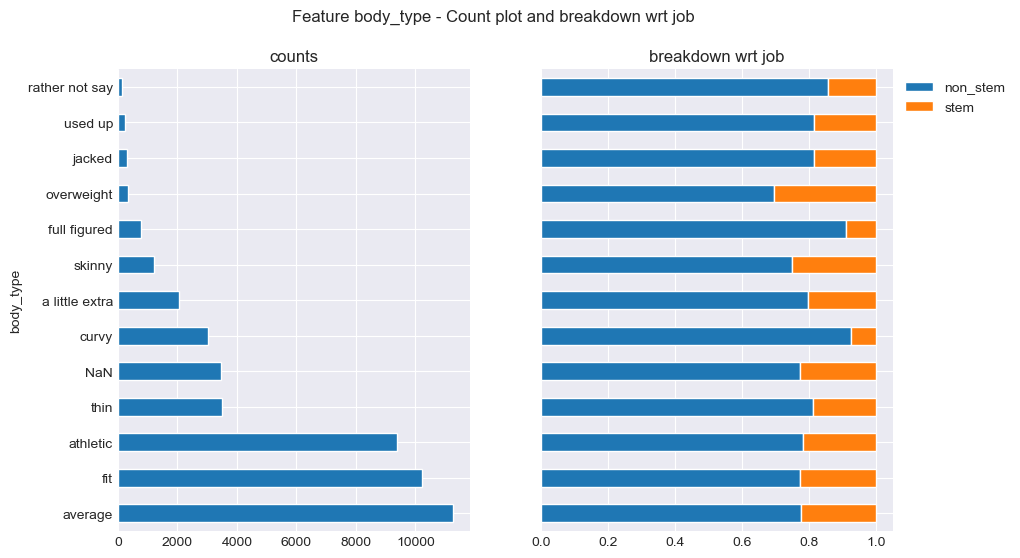

In [114]:
feature = "body_type"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

This shows I have to merge some levels:
* Merge rare level "rather not say" and "used up" with "NaN".
* Merge rare level "a little extra" with "overweight".
* Merge rare level "jacked" with "fit".
* Merge rare level "full figured" with "curvy" - here I'm assuming "curvy" does not mean a "dad bod".

### Processed `body_type` values

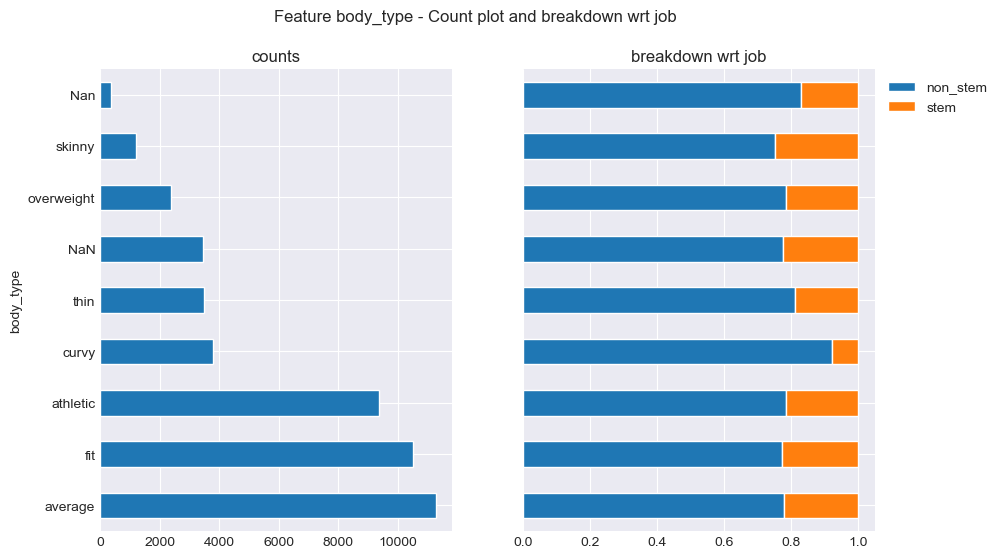

In [115]:
replace_map = {
    "rather not say": "Nan",
    "used up": "Nan",
    "a little extra": "overweight",
    "jacked": "fit",
    "full figured": "curvy",
}

df[feature] = df[feature].replace(replace_map)

display(Markdown(f"### Processed `{feature}` values"))
eda_cat(df, feature, target)

### `diet`

### Original `diet` values

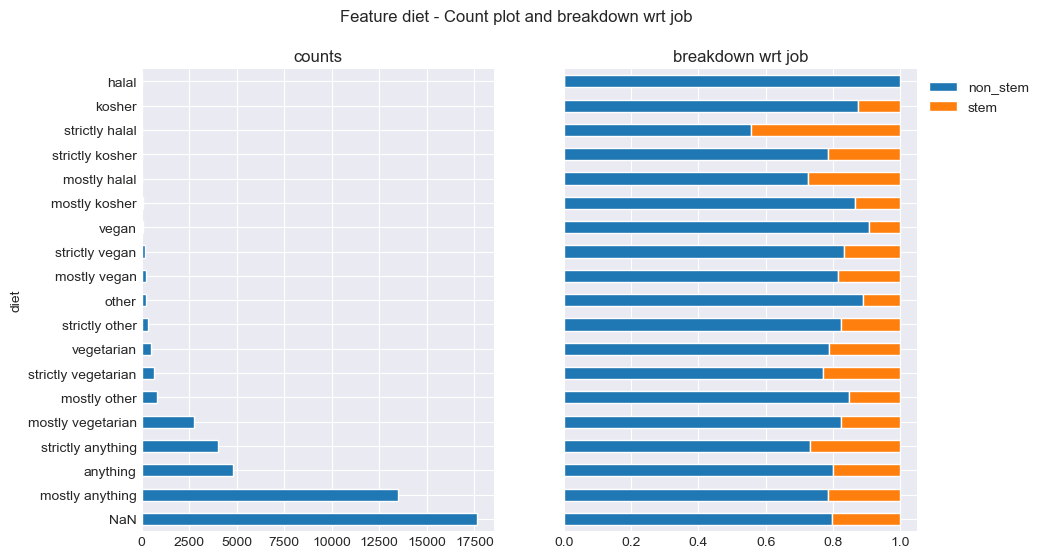

In [116]:
feature = "diet"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

This shows:
* Merge "strictly vegetarian" with "vegetarian".

In [117]:
df[feature] = df[feature].replace({
    "strictly vegetarian": "vegetarian",
})

* Treat all levels with frequency less that that of "strictly other" as rare and merge with "mostly other".

In [118]:
val_counts = df[feature].value_counts()
num_occur_for_strictly_other = val_counts["strictly other"]
categories_less_than_strictly_other = val_counts[val_counts < num_occur_for_strictly_other].index
for cat in categories_less_than_strictly_other:
    df[feature] = df[feature].replace(cat, "strictly other")

### Processed `diet` values

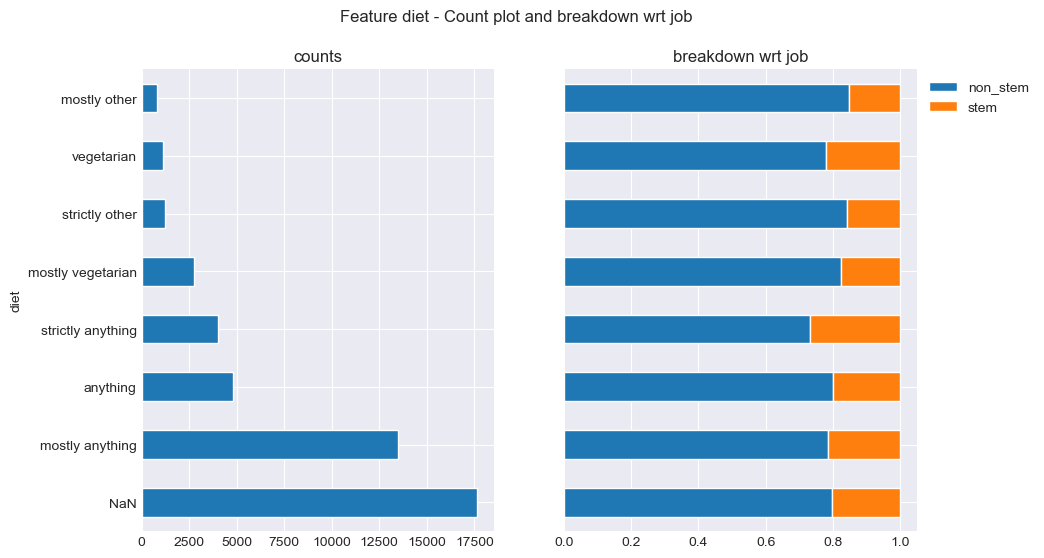

In [119]:
display(Markdown(f"### Processed `{feature}` values"))
eda_cat(df, feature, target)

### `drinks`

### Original `drinks` values

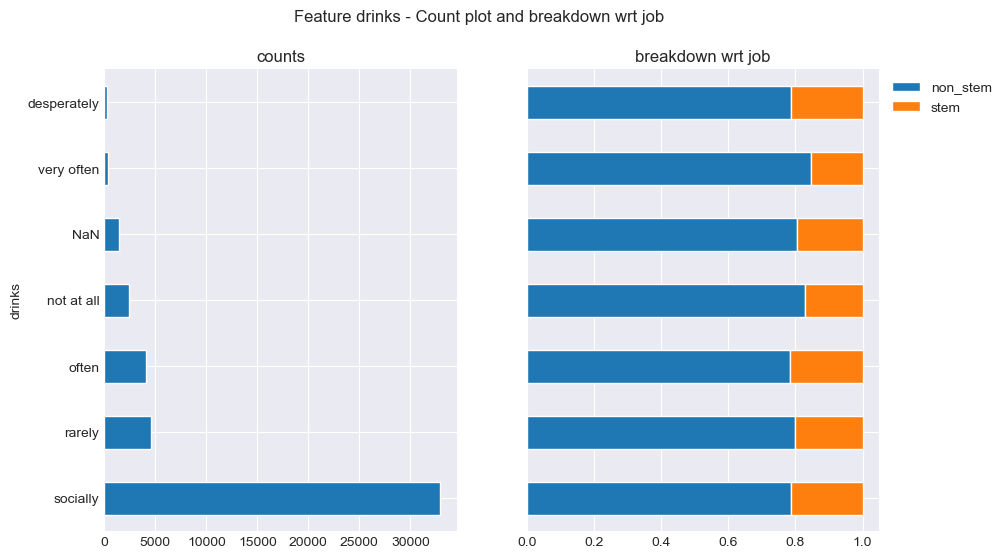

In [120]:
feature = "drinks"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``drugs``

### Original `drugs` values

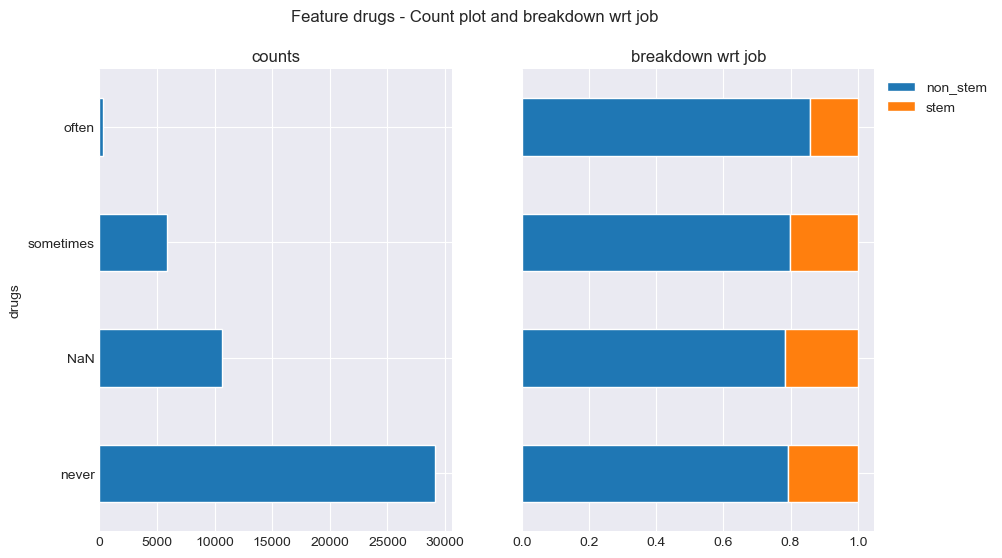

In [121]:
feature = "drugs"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``orientation``

### Original `education` values

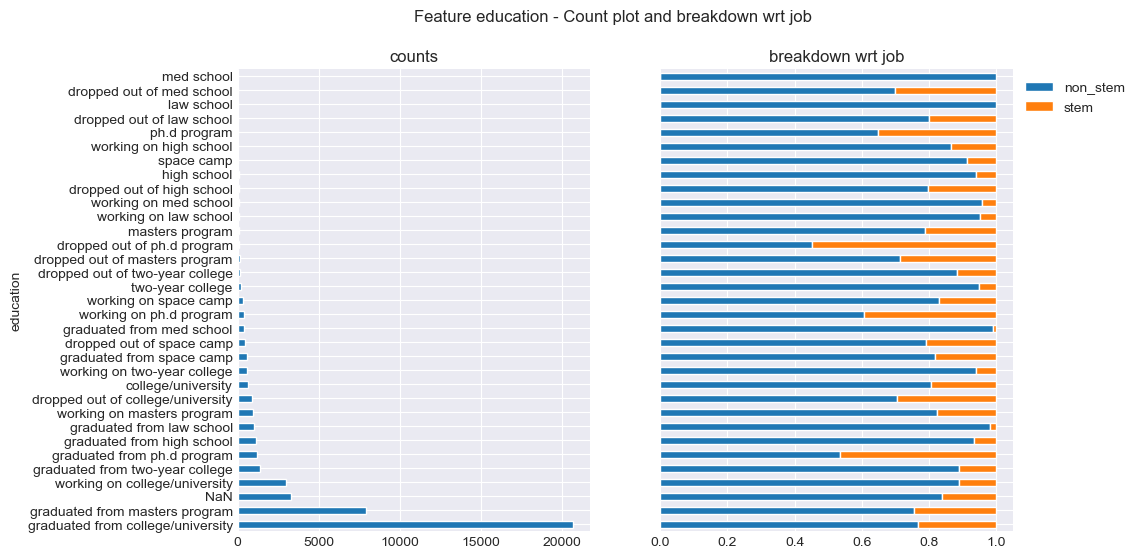

In [122]:
feature = "education"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``pets``

### Original `pets` values

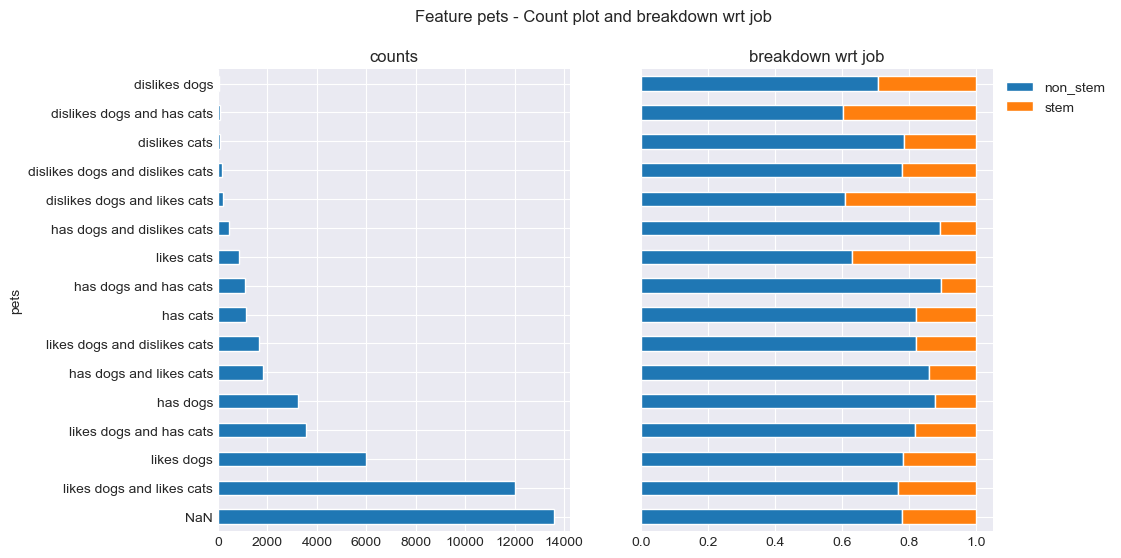

In [123]:
feature = "pets"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``sex``

### Original `religion` values

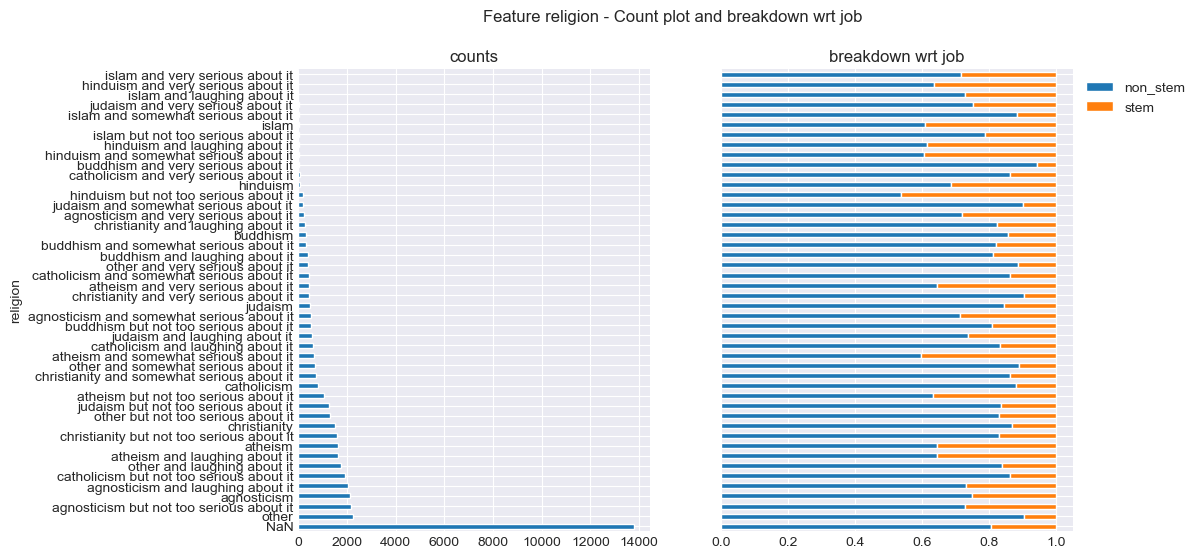

In [124]:
feature = "religion"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### ``smokes``

### Original `smokes` values

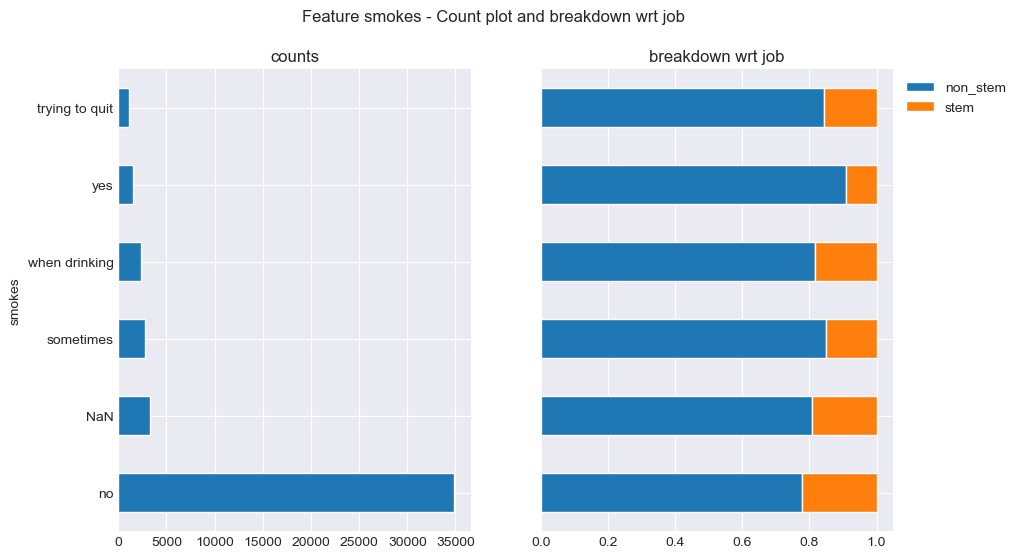

In [125]:
feature = "smokes"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

### `religion`

### Original `religion` values

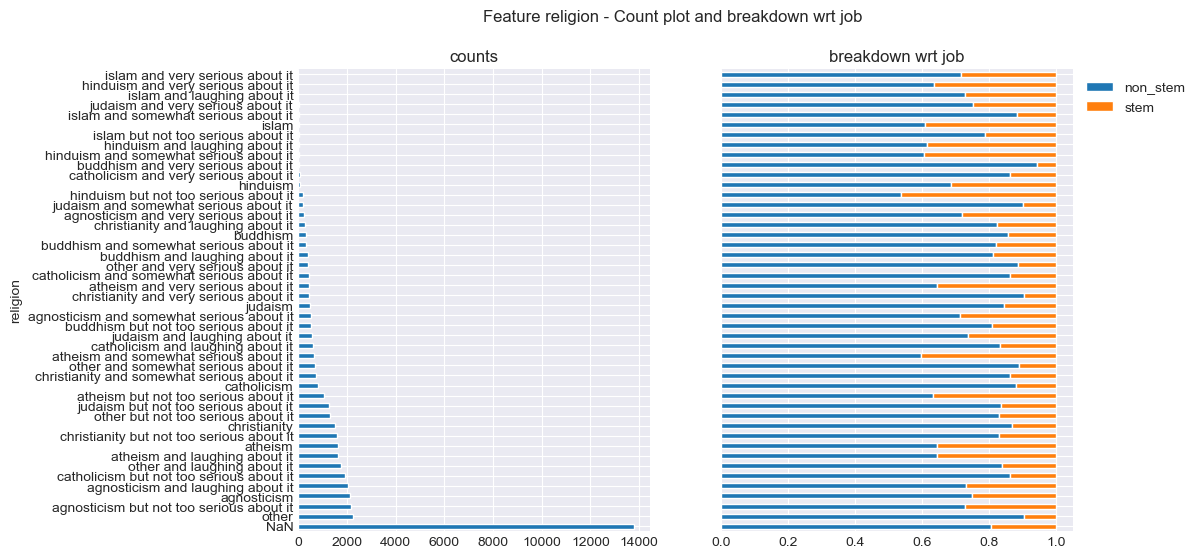

In [126]:
feature = "religion"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}

* Merge the religions without levels

In [127]:
levels = df[feature].unique().tolist()
religions = [r for r in levels if len(r.split())==1]

for religion in religions:
    criteria = df[feature].str.contains(religion)
    df.loc[criteria, feature] = religion

### Processed `religion` values

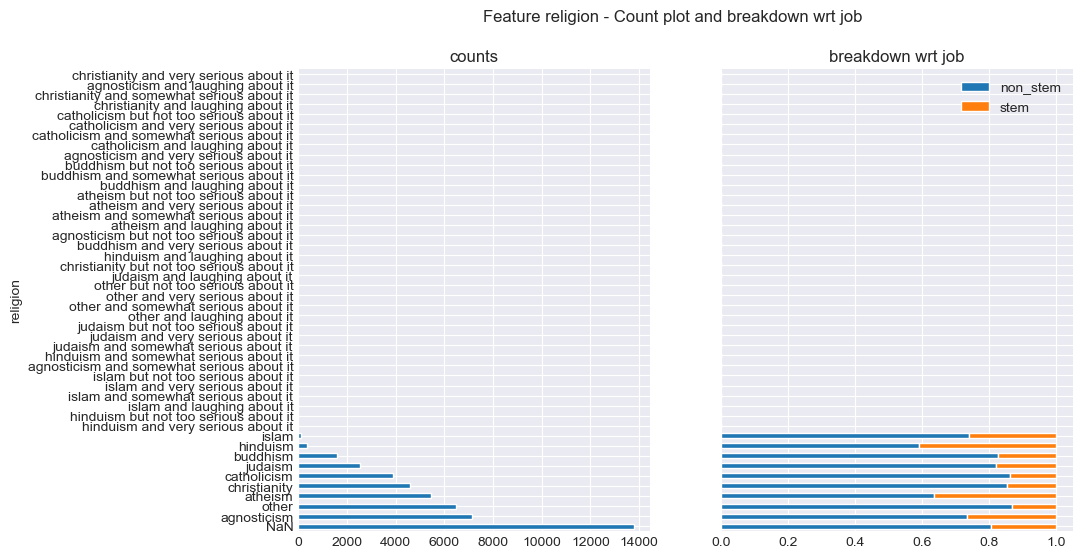

In [128]:
display(Markdown(f"### Processed `{feature}` values"))
eda_cat(df, feature, target)


### ``status``

### Original `status` values

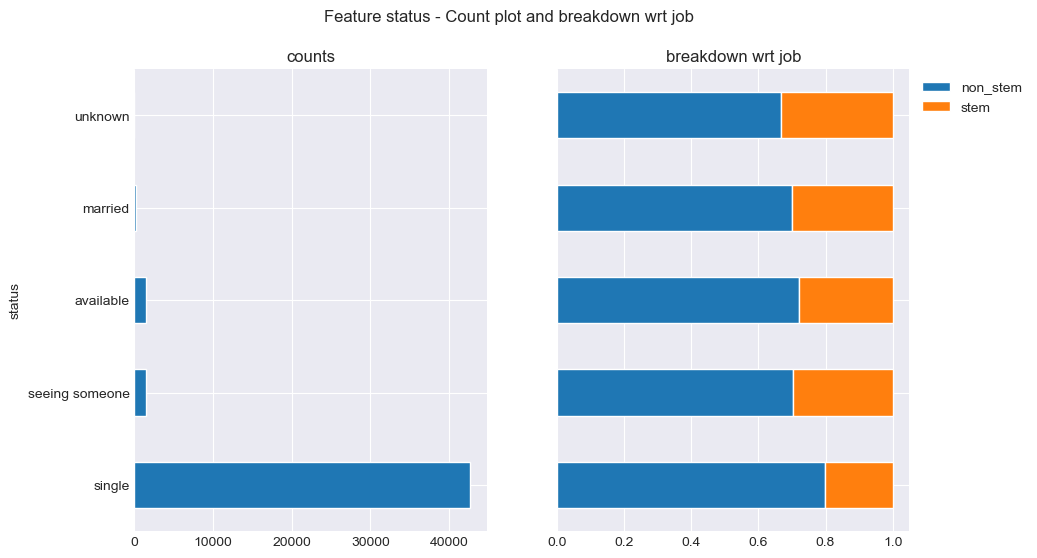

In [129]:
feature = "status"

display(Markdown(f"### Original `{feature}` values"))
eda_cat(df, feature, target)
cat_features |= {feature}


### ``age``

In [130]:
feature = "age"

num_features |= {feature}

### ``height``

In [131]:
feature = "height"

num_features |= {feature}

* Drop the rows with missing values

In [143]:
df = df.loc[df[feature].notna()].copy()

## Preprocessing

In [144]:
cat_features = list(cat_features)
num_features = list(num_features)
features = cat_features + num_features
print(f"cat_features: {cat_features}")
print(f"num_features: {num_features}")

cat_features: ['pets', 'status', 'drugs', 'religion', 'drinks', 'smokes', 'body_type', 'diet', 'education']
num_features: ['height', 'age']


In [145]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(df[features], df[target], train_size=0.6, stratify=df[target], random_state=SEED)
df_train.shape, df_test.shape

((27543, 11), (18363, 11))

In [146]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_e = OneHotEncoder()
num_e = StandardScaler()

data = cat_e.fit_transform(df_train[cat_features]).toarray()
index = df_train.index
columns = cat_e.get_feature_names_out()
df_cat = pd.DataFrame(data=data, index=index, columns=columns)

data = num_e.fit_transform(df_train[num_features])
index = df_train.index
columns = num_features
df_num = pd.DataFrame(data=data, index=index, columns=num_features)

df_train = pd.concat([df_cat, df_num], axis=1)

display(df_train.head(1))

y_train = y_train.map( {'non_stem':0, "stem":1} )

,pets_NaN,pets_dislikes cats,pets_dislikes dogs,pets_dislikes dogs and dislikes cats,pets_dislikes dogs and has cats,pets_dislikes dogs and likes cats,pets_has cats,pets_has dogs,pets_has dogs and dislikes cats,pets_has dogs and has cats,pets_has dogs and likes cats,pets_likes cats,pets_likes dogs,pets_likes dogs and dislikes cats,pets_likes dogs and has cats,pets_likes dogs and likes cats,status_available,status_married,status_seeing someone,status_single,status_unknown,drugs_NaN,drugs_never,drugs_often,drugs_sometimes,religion_NaN,religion_agnosticism,religion_atheism,religion_buddhism,religion_catholicism,religion_christianity,religion_hinduism,religion_islam,religion_judaism,religion_other,drinks_NaN,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,drinks_very often,smokes_NaN,smokes_no,smokes_sometimes,smokes_trying to quit,smokes_when drinking,smokes_yes,body_type_NaN,body_type_Nan,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_overweight,body_type_skinny,body_type_thin,diet_NaN,diet_anything,diet_mostly anything,diet_mostly other,diet_mostly vegetarian,diet_strictly anything,diet_strictly other,diet_vegetarian,education_NaN,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,education_graduated from two-year college,education_high school,education_law school,education_masters program,education_med school,education_ph.d program,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college,height,age
42096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.668087,-0.563824


## Base Learners / Estimators

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

In [148]:
models = {
    "LR": LogisticRegression(max_iter=1000),
    "DT": DecisionTreeClassifier(),
    #"KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(),
    "ET": ExtraTreesClassifier(),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
}

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [149]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [150]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
for name,model in models.items():
    scores = cross_val_score(model, df_train, y_train, cv=cv)
    print(name, scores.mean())

LR 0.7975892778298388
DT 0.6996335177211301
RF 0.7889483173789783
ET 0.7735541373906556


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.p

XGB 0.7974802794681091


## Stacked Learners

Notes:
Takes the probabilities of a set of base learners and creates a mixed model to make the final prediction.


In [151]:
from sklearn.ensemble import StackingClassifier

``level_1_model`` - Combines the models using "LR" or Logistic Regression.

In [152]:
level_0_models = models
level_1_model = models['LR']

In [153]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

stacking_model = StackingClassifier(
    estimators=list(level_0_models.items()), final_estimator=level_1_model, 
    passthrough=True, cv=cv, stack_method="predict_proba")

In [154]:
tmp = stacking_model.fit_transform(df_train, y_train)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [155]:
level_0_columns = [f"{name}_prediction" for name in models.keys()]

df_stacked = pd.DataFrame(tmp, columns=level_0_columns+list(df_train.columns))
df_stacked.head()

,LR_prediction,DT_prediction,RF_prediction,ET_prediction,XGB_prediction,pets_NaN,pets_dislikes cats,pets_dislikes dogs,pets_dislikes dogs and dislikes cats,pets_dislikes dogs and has cats,pets_dislikes dogs and likes cats,pets_has cats,pets_has dogs,pets_has dogs and dislikes cats,pets_has dogs and has cats,pets_has dogs and likes cats,pets_likes cats,pets_likes dogs,pets_likes dogs and dislikes cats,pets_likes dogs and has cats,pets_likes dogs and likes cats,status_available,status_married,status_seeing someone,status_single,status_unknown,drugs_NaN,drugs_never,drugs_often,drugs_sometimes,religion_NaN,religion_agnosticism,religion_atheism,religion_buddhism,religion_catholicism,religion_christianity,religion_hinduism,religion_islam,religion_judaism,religion_other,drinks_NaN,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,drinks_very often,smokes_NaN,smokes_no,smokes_sometimes,smokes_trying to quit,smokes_when drinking,smokes_yes,body_type_NaN,body_type_Nan,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_overweight,body_type_skinny,body_type_thin,diet_NaN,diet_anything,diet_mostly anything,diet_mostly other,diet_mostly vegetarian,diet_strictly anything,diet_strictly other,diet_vegetarian,education_NaN,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,education_graduated from law school,education_graduated from masters program,education_graduated from med school,education_graduated from ph.d program,education_graduated from space camp,education_graduated from two-year college,education_high school,education_law school,education_masters program,education_med school,education_ph.d program,education_space camp,education_two-year college,education_working on college/university,education_working on high school,education_working on law school,education_working on masters program,education_working on med school,education_working on ph.d program,education_working on space camp,education_working on two-year college,height,age
0,0.123780,0.0,0.05,0.0,0.135828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.668087,-0.563824
1,0.291381,0.0,0.11,0.0,0.276075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.098424,-0.457097
2,0.280329,1.0,0.73,1.0,0.346280,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.923591,-0.457097
3,0.152983,0.0,0.13,0.0,0.167276,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

In [158]:
scores = cross_val_score(stacking_model, df_train, y_train, cv=10)
scores.mean(), scores.std()

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\ProgramData\anaconda3\Lib\site-packages\xgboost\sklearn.p

In [ ]:
y_pred = stacking_model.predict(df_test)
y_true = y_test

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))